In [1]:
from sklearn.cluster import DBSCAN, dbscan
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder


In [2]:
df = pd.read_csv("Experimental_data_aged_cell.csv")
soc_ocv=pd.read_csv('OCV_vs_SOC_curve.csv')

In [3]:
df.head()

,Time,Current,Voltage,Temperature
0,0.000000,2.360728,2.999311,27.449894
1,1.000008,2.303036,2.999813,27.724861
2,2.000008,2.284371,2.999863,27.545357
3,3.000008,2.221588,2.999863,27.457523
4,4.000008,2.158805,2.999813,27.484249


In [4]:
soc_ocv.head()

,SOC,V0
0,0.000,3.010470
1,0.001,3.031911
2,0.002,3.049571
3,0.003,3.065900
4,0.004,3.080937


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307513 entries, 0 to 307512
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Time         307513 non-null  float64
 1   Current      307513 non-null  float64
 2   Voltage      307513 non-null  float64
 3   Temperature  307513 non-null  float64
dtypes: float64(4)
memory usage: 9.4 MB


In [6]:
df.shape

(307513, 4)

In [7]:
df.isna().sum()

Time           0
Current        0
Voltage        0
Temperature    0
dtype: int64

In [8]:
df.isnull().sum()

Time           0
Current        0
Voltage        0
Temperature    0
dtype: int64

In [9]:
columns=df.columns

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Time,307513.0,153756.000008,88771.501002,0.000000,76878.000008,153756.000008,230634.000008,307512.000008
Current,307513.0,-0.163968,17.285349,-20.152779,-19.996674,-4.350225,19.973799,33.203965
Voltage,307513.0,3.849060,0.206192,2.998059,3.726224,3.858586,3.996411,4.208818
Temperature,307513.0,26.320183,0.433726,25.112604,25.941347,26.372910,26.640247,28.110600


In [11]:
df.corr()

,Time,Current,Voltage,Temperature
Time,1.000000,0.001848,0.114479,-0.586582
Current,0.001848,1.000000,-0.531682,-0.173108
Voltage,0.114479,-0.531682,1.000000,-0.073659
Temperature,-0.586582,-0.173108,-0.073659,1.000000


In [12]:
df.value_counts('Voltage')

Voltage
4.199239    1310
4.199289    1275
4.199339    1243
4.199189    1155
4.199139    1094
            ... 
3.393240       1
3.393039       1
3.392989       1
3.392638       1
4.208818       1
Name: count, Length: 25672, dtype: int64

In [13]:
second = df['Time'] / 3600
df['Time(hr)'] = second
RatedCapacity = 16.62
Capacity = df['Current'] * df['Time(hr)']
df['Capacity'] = Capacity
df.to_csv('Experimental_data_aged_cell_added.csv', index=False) 
df.head(10)

,Time,Current,Voltage,Temperature,Time(hr),Capacity
0,0.000000,2.360728,2.999311,27.449894,0.000000,0.000000
1,1.000008,2.303036,2.999813,27.724861,0.000278,0.000640
2,2.000008,2.284371,2.999863,27.545357,0.000556,0.001269
3,3.000008,2.221588,2.999863,27.457523,0.000833,0.001851
4,4.000008,2.158805,2.999813,27.484249,0.001111,0.002399
5,5.000008,2.096023,2.999311,27.671408,0.001389,0.002911
6,6.000008,2.040028,2.999562,27.610302,0.001667,0.003400
7,7.000008,2.028150,2.999913,27.499533,0.001944,0.003944
8,8.000015,-20.049273,3.108820,27.526283,0.002222,-0.044554
9,9.000000,-20.017035,3.119144,27.476620,0.002500,-0.050043


In [14]:
max_value = df['Capacity'].max()
print("Maximum value:", max_value)

Maximum value: 2701.3757856324996


In [15]:
# Rated capacity of the battery in Ah
# Initial SoC (e.g., 100% at start)
SoC_init = 100

# Sort by time
#df = df.sort_values('time').reset_index(drop=True)

# Calculate time difference in hours
#df['delta_t'] = df['time'].diff().fillna(0) / 3600  # seconds to hours

# Calculate change in charge (Ah) for each interval

# Calculate SoC iteratively
SoC = [SoC_init]
for dq in df['Capacity'][1:]:
    SoC_new = SoC[-1] - (dq / RatedCapacity) * 100  # subtract discharged charge percentage
    SoC.append(max(min(SoC_new, 100), 0))  # bound SoC between 0 and 100


df['SOC Acquisition (%)'] = SoC 

df.head(10)

,Time,Current,Voltage,Temperature,Time(hr),Capacity,SOC Acquisition (%)
0,0.000000,2.360728,2.999311,27.449894,0.000000,0.000000,100.000000
1,1.000008,2.303036,2.999813,27.724861,0.000278,0.000640,99.996151
2,2.000008,2.284371,2.999863,27.545357,0.000556,0.001269,99.988515
3,3.000008,2.221588,2.999863,27.457523,0.000833,0.001851,99.977376
4,4.000008,2.158805,2.999813,27.484249,0.001111,0.002399,99.962943
5,5.000008,2.096023,2.999311,27.671408,0.001389,0.002911,99.945427
6,6.000008,2.040028,2.999562,27.610302,0.001667,0.003400,99.924970
7,7.000008,2.028150,2.999913,27.499533,0.001944,0.003944,99.901241
8,8.000015,-20.049273,3.108820,27.526283,0.002222,-0.044554,100.000000
9,9.000000,-20.017035,3.119144,27.476620,0.002500,-0.050043,100.000000


In [16]:
Cn = 16.62  # Battery nominal capacity in Ah
initial_soc = 1.0  # Start from 100% SOC

# Make sure data is sorted by time
#df = df.sort_values(by='Time(hr)').reset_index(drop=True)

# Compute delta time between samples (perbandingan waktu each rows)
df['Delta_t'] = df['Time(hr)'].diff().fillna(0)  # in hours

# Apply coulomb counting
soc = [initial_soc]
for i in range(1, len(df)):
    delta_soc = df.loc[i, 'Current'] * df.loc[i, 'Delta_t'] / Cn
    soc.append(soc[-1] - delta_soc)

# Add SOC to dataframe
df['SOC_CC'] = [min(max(s, 0), 1) for s in soc]  # Clamp between 0 and 1

# Optional: convert to percentage
df['SOC_CC(%)'] = df['SOC_CC'] * 100

# Show result
df.head(20)

,Time,Current,Voltage,Temperature,Time(hr),Capacity,SOC Acquisition (%),Delta_t,SOC_CC,SOC_CC(%)
0,0.000000,2.360728,2.999311,27.449894,0.000000,0.000000,100.000000,0.000000,1.000000,100.000000
1,1.000008,2.303036,2.999813,27.724861,0.000278,0.000640,99.996151,0.000278,0.999962,99.996151
2,2.000008,2.284371,2.999863,27.545357,0.000556,0.001269,99.988515,0.000278,0.999923,99.992333
3,3.000008,2.221588,2.999863,27.457523,0.000833,0.001851,99.977376,0.000278,0.999886,99.988620
4,4.000008,2.158805,2.999813,27.484249,0.001111,0.002399,99.962943,0.000278,0.999850,99.985012
5,5.000008,2.096023,2.999311,27.671408,0.001389,0.002911,99.945427,0.000278,0.999815,99.981508
6,6.000008,2.040028,2.999562,27.610302,0.001667,0.003400,99.924970,0.000278,0.999781,99.978099
7,7.000008,2.028150,2.999913,27.499533,0.001944,0.003944,99.901241,0.000278,0.999747,99.974709
8,8.000015,-20.049273,3.108820,27.526283,0.002222,-0.044554,100.000000,0.000278,1.000000,100.000000
9,9.000000,-20.017035,3.119144,27.476620,0.002500,-0.050043,100.000000,0.000278,1.000000,100.000000


In [17]:
import pandas as pd

Cn = 16.62  # Battery nominal capacity in Ah
initial_soc = 0  # Start from 100% SOC

# Assuming df has columns 'Time(hr)' and 'Current' (in Amps)
# Make sure data is sorted by time
df = df.sort_values(by='Time(hr)').reset_index(drop=True)

# Calculate delta time in seconds (convert hours to seconds)
df['Delta_t'] = df['Time(hr)'].diff().fillna(0) * 3600  # seconds

# Convert capacity to Coulombs (Ah * 3600)
Cn_coulombs = Cn * 3600

# Calculate incremental charge (Current * Delta_t) in Coulombs
df['Charge_delta'] = df['Current'] * df['Delta_t']  # Ampere-seconds (Coulombs)

# Calculate cumulative charge removed/added (integral of current over time)
df['Cumulative_charge'] = df['Charge_delta'].cumsum()

# Calculate SOC using Coulomb counting formula:
# SOC(t) = SOC0 - (1/Cn) * integral(I dt)
df['SOC_CC'] = initial_soc - (df['Cumulative_charge'] / Cn_coulombs)

# Clamp SOC between 0 and 1
df['SOC_CC'] = df['SOC_CC'].clip(lower=0, upper=1)

# Optional: convert SOC to percentage
df['SOC_CC(%)'] = df['SOC_CC'] * 100

# Show first 20 rows
df.head(20)

,Time,Current,Voltage,Temperature,Time(hr),Capacity,SOC Acquisition (%),Delta_t,SOC_CC,SOC_CC(%),Charge_delta,Cumulative_charge
0,0.000000,2.360728,2.999311,27.449894,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.000008,2.303036,2.999813,27.724861,0.000278,0.000640,99.996151,1.000008,0.000000,0.000000,2.303054,2.303054
2,2.000008,2.284371,2.999863,27.545357,0.000556,0.001269,99.988515,1.000000,0.000000,0.000000,2.284371,4.587424
3,3.000008,2.221588,2.999863,27.457523,0.000833,0.001851,99.977376,1.000000,0.000000,0.000000,2.221588,6.809013
4,4.000008,2.158805,2.999813,27.484249,0.001111,0.002399,99.962943,1.000000,0.000000,0.000000,2.158805,8.967818
5,5.000008,2.096023,2.999311,27.671408,0.001389,0.002911,99.945427,1.000000,0.000000,0.000000,2.096023,11.063841
6,6.000008,2.040028,2.999562,27.610302,0.001667,0.003400,99.924970,1.000000,0.000000,0.000000,2.040028,13.103869
7,7.000008,2.028150,2.999913,27.499533,0.001944,0.003944,99.901241,1.000000,0.000000,0.000000,2.028150,15.132019
8,8.000015,-20.049273,3.108820,27.526283,0.002222,-0.044554,100.000000,1.000008,0.000082,0.008219,-20.049426,-4.917407
9,9.000000,-20.017035,3.119144,27.476620,0.002500,-0.050043,100.000000,0.999985,0.000417,0.041674,-20.016730,-24.934137


In [18]:
# Interpolate SoC based on Voltage using soc_ocv mapping
soc_estimates = np.interp(df['Voltage'], soc_ocv['V0'], soc_ocv['SOC'])

# Add the interpolated SoC values as a new column to the DataFrame
df['SOC Prediction (%)'] = soc_estimates * 100 # Convert to percentage if needed
df.head(20)

,Time,Current,Voltage,Temperature,Time(hr),Capacity,SOC Acquisition (%),Delta_t,SOC_CC,SOC_CC(%),Charge_delta,Cumulative_charge,SOC Prediction (%)
0,0.000000,2.360728,2.999311,27.449894,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.000008,2.303036,2.999813,27.724861,0.000278,0.000640,99.996151,1.000008,0.000000,0.000000,2.303054,2.303054,0.000000
2,2.000008,2.284371,2.999863,27.545357,0.000556,0.001269,99.988515,1.000000,0.000000,0.000000,2.284371,4.587424,0.000000
3,3.000008,2.221588,2.999863,27.457523,0.000833,0.001851,99.977376,1.000000,0.000000,0.000000,2.221588,6.809013,0.000000
4,4.000008,2.158805,2.999813,27.484249,0.001111,0.002399,99.962943,1.000000,0.000000,0.000000,2.158805,8.967818,0.000000
5,5.000008,2.096023,2.999311,27.671408,0.001389,0.002911,99.945427,1.000000,0.000000,0.000000,2.096023,11.063841,0.000000
6,6.000008,2.040028,2.999562,27.610302,0.001667,0.003400,99.924970,1.000000,0.000000,0.000000,2.040028,13.103869,0.000000
7,7.000008,2.028150,2.999913,27.499533,0.001944,0.003944,99.901241,1.000000,0.000000,0.000000,2.028150,15.132019,0.000000
8,8.000015,-20.049273,3.108820,27.526283,0.002222,-0.044554,100.000000,1.000008,0.000082,0.008219,-20.049426,-4.917407,0.602738
9,9.000000,-20.017035,3.119144,27.476620,0.002500,-0.050043,100.000000,0.999985,0.000417,0.041674,-20.016730,-24.934137,0.684802


In [19]:
df['SOC Error (%)'] = df['SOC Prediction (%)'] - df['SOC_CC(%)']
df.head(20)

,Time,Current,Voltage,Temperature,Time(hr),Capacity,SOC Acquisition (%),Delta_t,SOC_CC,SOC_CC(%),Charge_delta,Cumulative_charge,SOC Prediction (%),SOC Error (%)
0,0.000000,2.360728,2.999311,27.449894,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.000008,2.303036,2.999813,27.724861,0.000278,0.000640,99.996151,1.000008,0.000000,0.000000,2.303054,2.303054,0.000000,0.000000
2,2.000008,2.284371,2.999863,27.545357,0.000556,0.001269,99.988515,1.000000,0.000000,0.000000,2.284371,4.587424,0.000000,0.000000
3,3.000008,2.221588,2.999863,27.457523,0.000833,0.001851,99.977376,1.000000,0.000000,0.000000,2.221588,6.809013,0.000000,0.000000
4,4.000008,2.158805,2.999813,27.484249,0.001111,0.002399,99.962943,1.000000,0.000000,0.000000,2.158805,8.967818,0.000000,0.000000
5,5.000008,2.096023,2.999311,27.671408,0.001389,0.002911,99.945427,1.000000,0.000000,0.000000,2.096023,11.063841,0.000000,0.000000
6,6.000008,2.040028,2.999562,27.610302,0.001667,0.003400,99.924970,1.000000,0.000000,0.000000,2.040028,13.103869,0.000000,0.000000
7,7.000008,2.028150,2.999913,27.499533,0.001944,0.003944,99.901241,1.000000,0.000000,0.000000,2.028150,15.132019,0.000000,0.000000
8,8.000015,-20.049273,3.108820,27.526283,0.002222,-0.044554,100.000000,1.000008,0.000082,0.008219,-20.049426,-4.917407,0.602738,0.594519
9,9.000000,-20.017035,3.119144,27.476620,0.002500,-0.050043,100.000000,0.999985,0.000417,0.041674,-20.016730,-24.934137,0.684802,0.643128


In [20]:
df['Absolute Error (%)'] = abs(df['SOC Error (%)'])

mse = (df['SOC Error (%)'] ** 2).mean()
mae = df['Absolute Error (%)'].mean()
df.head(20)

,Time,Current,Voltage,Temperature,Time(hr),Capacity,SOC Acquisition (%),Delta_t,SOC_CC,SOC_CC(%),Charge_delta,Cumulative_charge,SOC Prediction (%),SOC Error (%),Absolute Error (%)
0,0.000000,2.360728,2.999311,27.449894,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.000008,2.303036,2.999813,27.724861,0.000278,0.000640,99.996151,1.000008,0.000000,0.000000,2.303054,2.303054,0.000000,0.000000,0.000000
2,2.000008,2.284371,2.999863,27.545357,0.000556,0.001269,99.988515,1.000000,0.000000,0.000000,2.284371,4.587424,0.000000,0.000000,0.000000
3,3.000008,2.221588,2.999863,27.457523,0.000833,0.001851,99.977376,1.000000,0.000000,0.000000,2.221588,6.809013,0.000000,0.000000,0.000000
4,4.000008,2.158805,2.999813,27.484249,0.001111,0.002399,99.962943,1.000000,0.000000,0.000000,2.158805,8.967818,0.000000,0.000000,0.000000
5,5.000008,2.096023,2.999311,27.671408,0.001389,0.002911,99.945427,1.000000,0.000000,0.000000,2.096023,11.063841,0.000000,0.000000,0.000000
6,6.000008,2.040028,2.999562,27.610302,0.001667,0.003400,99.924970,1.000000,0.000000,0.000000,2.040028,13.103869,0.000000,0.000000,0.000000
7,7.000008,2.028150,2.999913,27.499533,0.001944,0.003944,99.901241,1.000000,0.000000,0.000000,2.028150,15.132019,0.000000,0.000000,0.000000
8,8.000015,-20.049273,3.108820,27.526283,0.002222,-0.044554,100.000000,1.000008,0.000082,0.008219,-20.049426,-4.917407,0.602738,0.594519,0.594519
9,9.000000,-20.017035,3.119144,27.476620,0.002500,-0.050043,100.000000,0.999985,0.000417,0.041674,-20.016730,-24.934137,0.684802,0.643128,0.643128


In [21]:
max_value = df['SOC Error (%)'].max()
print("Maximum value:", max_value)

Maximum value: 35.19789869475878


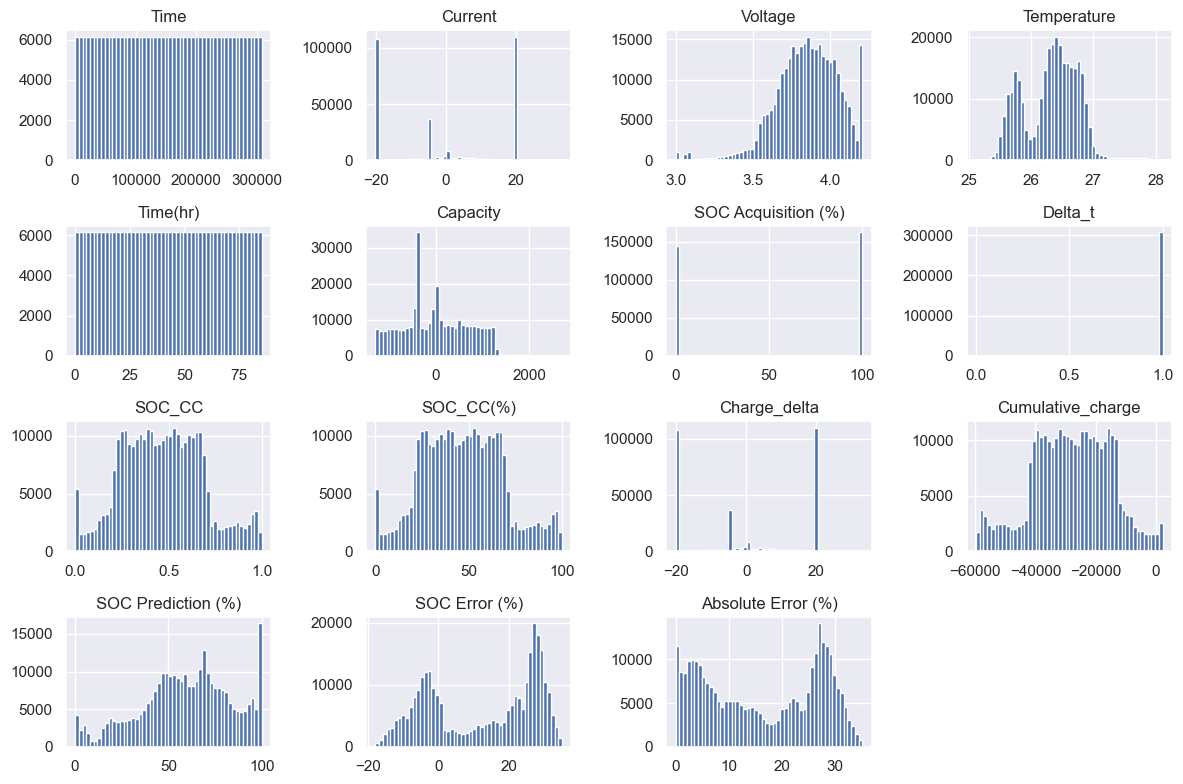

In [22]:
df.hist(bins=50 , figsize=(12,8))
plt.tight_layout()
plt.show()

In [23]:
print(df.columns)

Index(['Time', 'Current', 'Voltage', 'Temperature', 'Time(hr)', 'Capacity',
       'SOC Acquisition (%)', 'Delta_t', 'SOC_CC', 'SOC_CC(%)', 'Charge_delta',
       'Cumulative_charge', 'SOC Prediction (%)', 'SOC Error (%)',
       'Absolute Error (%)'],
      dtype='object')


In [24]:
merged_subset = df.iloc[1:82801]
merged_subset.to_csv('subset_file.csv', index=False)
merged_subset.head(10)

,Time,Current,Voltage,Temperature,Time(hr),Capacity,SOC Acquisition (%),Delta_t,SOC_CC,SOC_CC(%),Charge_delta,Cumulative_charge,SOC Prediction (%),SOC Error (%),Absolute Error (%)
1,1.000008,2.303036,2.999813,27.724861,0.000278,0.000640,99.996151,1.000008,0.000000,0.000000,2.303054,2.303054,0.000000,0.000000,0.000000
2,2.000008,2.284371,2.999863,27.545357,0.000556,0.001269,99.988515,1.000000,0.000000,0.000000,2.284371,4.587424,0.000000,0.000000,0.000000
3,3.000008,2.221588,2.999863,27.457523,0.000833,0.001851,99.977376,1.000000,0.000000,0.000000,2.221588,6.809013,0.000000,0.000000,0.000000
4,4.000008,2.158805,2.999813,27.484249,0.001111,0.002399,99.962943,1.000000,0.000000,0.000000,2.158805,8.967818,0.000000,0.000000,0.000000
5,5.000008,2.096023,2.999311,27.671408,0.001389,0.002911,99.945427,1.000000,0.000000,0.000000,2.096023,11.063841,0.000000,0.000000,0.000000
6,6.000008,2.040028,2.999562,27.610302,0.001667,0.003400,99.924970,1.000000,0.000000,0.000000,2.040028,13.103869,0.000000,0.000000,0.000000
7,7.000008,2.028150,2.999913,27.499533,0.001944,0.003944,99.901241,1.000000,0.000000,0.000000,2.028150,15.132019,0.000000,0.000000,0.000000
8,8.000015,-20.049273,3.108820,27.526283,0.002222,-0.044554,100.000000,1.000008,0.000082,0.008219,-20.049426,-4.917407,0.602738,0.594519,0.594519
9,9.000000,-20.017035,3.119144,27.476620,0.002500,-0.050043,100.000000,0.999985,0.000417,0.041674,-20.016730,-24.934137,0.684802,0.643128,0.643128
10,10.000008,-20.013641,3.128115,27.549194,0.002778,-0.055593,100.000000,1.000008,0.000751,0.075124,-20.013794,-44.947930,0.759230,0.684106,0.684106


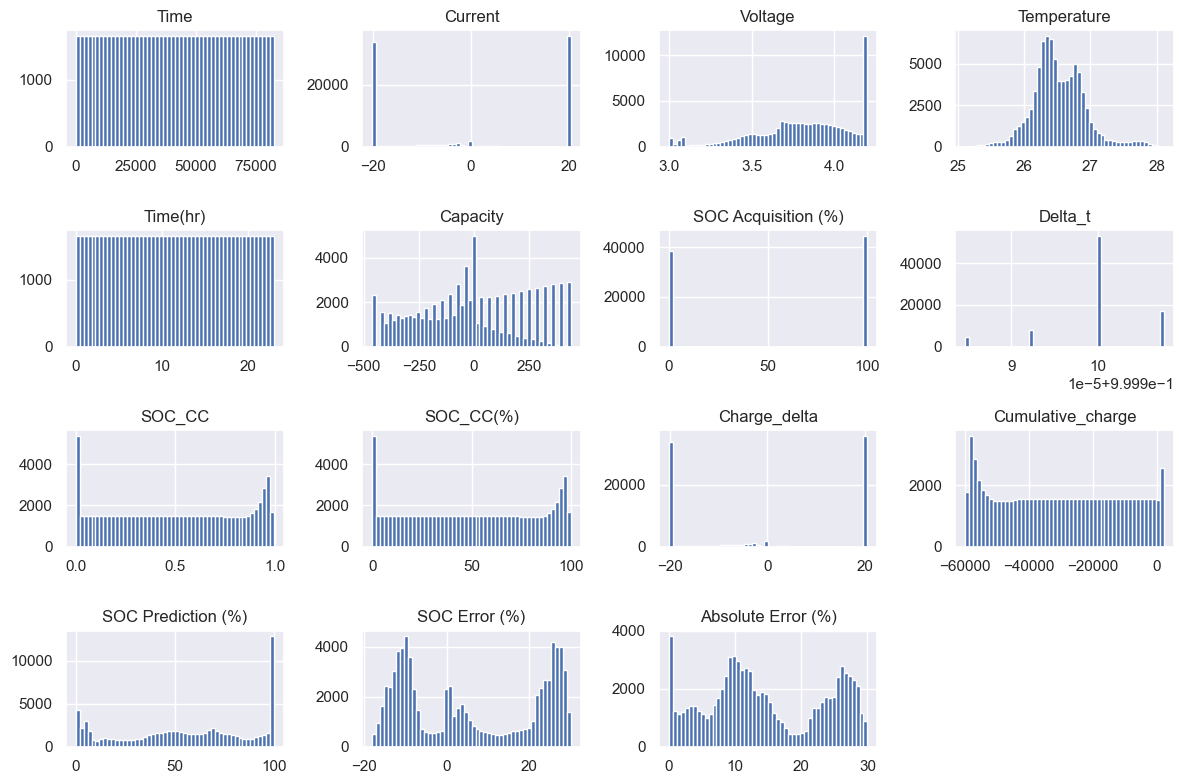

In [25]:
merged_subset.hist(bins=50 , figsize=(12,8))
plt.tight_layout()
plt.show()

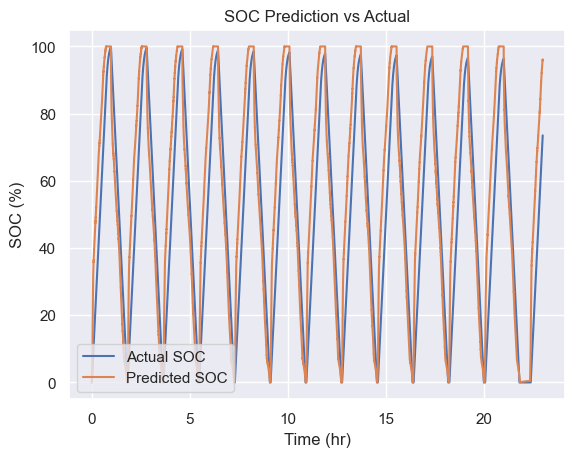

In [26]:
plt.plot(merged_subset['Time(hr)'], merged_subset['SOC_CC(%)'], label='Actual SOC')
plt.plot(merged_subset['Time(hr)'], merged_subset['SOC Prediction (%)'], label='Predicted SOC')
plt.xlabel('Time (hr)')
plt.ylabel('SOC (%)')
plt.legend()
plt.title('SOC Prediction vs Actual')
plt.show()

In [27]:
df['Significant Error'] = df['Absolute Error (%)'] > 10
df.head(20)

,Time,Current,Voltage,Temperature,Time(hr),Capacity,SOC Acquisition (%),Delta_t,SOC_CC,SOC_CC(%),Charge_delta,Cumulative_charge,SOC Prediction (%),SOC Error (%),Absolute Error (%),Significant Error
0,0.000000,2.360728,2.999311,27.449894,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False
1,1.000008,2.303036,2.999813,27.724861,0.000278,0.000640,99.996151,1.000008,0.000000,0.000000,2.303054,2.303054,0.000000,0.000000,0.000000,False
2,2.000008,2.284371,2.999863,27.545357,0.000556,0.001269,99.988515,1.000000,0.000000,0.000000,2.284371,4.587424,0.000000,0.000000,0.000000,False
3,3.000008,2.221588,2.999863,27.457523,0.000833,0.001851,99.977376,1.000000,0.000000,0.000000,2.221588,6.809013,0.000000,0.000000,0.000000,False
4,4.000008,2.158805,2.999813,27.484249,0.001111,0.002399,99.962943,1.000000,0.000000,0.000000,2.158805,8.967818,0.000000,0.000000,0.000000,False
5,5.000008,2.096023,2.999311,27.671408,0.001389,0.002911,99.945427,1.000000,0.000000,0.000000,2.096023,11.063841,0.000000,0.000000,0.000000,False
6,6.000008,2.040028,2.999562,27.610302,0.001667,0.003400,99.924970,1.000000,0.000000,0.000000,2.040028,13.103869,0.000000,0.000000,0.000000,False
7,7.000008,2.028150,2.999913,27.499533,0.001944,0.003944,99.901241,1.000000,0.000000,0.000000,2.028150,15.132019,0.000000,0.000000,0.000000,False
8,8.000015,-20.049273,3.108820,27.526283,0.002222,-0.044554,100.000000,1.000008,0.000082,0.008219,-20.049426,-4.917407,0.602738,0.594519,0.594519,False
9,9.000000,-20.017035,3.119144,27.476620,0.002500,-0.050043,100.000000,0.999985,0.000417,0.041674,-20.016730,-24.934137,0.684802,0.643128,0.643128,False


In [28]:
merged_subset['Status'] = merged_subset['Capacity'].apply(lambda x: 'charging' if x >= 0 else 'discharge')
merged_subset.head(15)

,Time,Current,Voltage,Temperature,Time(hr),Capacity,SOC Acquisition (%),Delta_t,SOC_CC,SOC_CC(%),Charge_delta,Cumulative_charge,SOC Prediction (%),SOC Error (%),Absolute Error (%),Status
1,1.000008,2.303036,2.999813,27.724861,0.000278,0.000640,99.996151,1.000008,0.000000,0.000000,2.303054,2.303054,0.000000,0.000000,0.000000,charging
2,2.000008,2.284371,2.999863,27.545357,0.000556,0.001269,99.988515,1.000000,0.000000,0.000000,2.284371,4.587424,0.000000,0.000000,0.000000,charging
3,3.000008,2.221588,2.999863,27.457523,0.000833,0.001851,99.977376,1.000000,0.000000,0.000000,2.221588,6.809013,0.000000,0.000000,0.000000,charging
4,4.000008,2.158805,2.999813,27.484249,0.001111,0.002399,99.962943,1.000000,0.000000,0.000000,2.158805,8.967818,0.000000,0.000000,0.000000,charging
5,5.000008,2.096023,2.999311,27.671408,0.001389,0.002911,99.945427,1.000000,0.000000,0.000000,2.096023,11.063841,0.000000,0.000000,0.000000,charging
6,6.000008,2.040028,2.999562,27.610302,0.001667,0.003400,99.924970,1.000000,0.000000,0.000000,2.040028,13.103869,0.000000,0.000000,0.000000,charging
7,7.000008,2.028150,2.999913,27.499533,0.001944,0.003944,99.901241,1.000000,0.000000,0.000000,2.028150,15.132019,0.000000,0.000000,0.000000,charging
8,8.000015,-20.049273,3.108820,27.526283,0.002222,-0.044554,100.000000,1.000008,0.000082,0.008219,-20.049426,-4.917407,0.602738,0.594519,0.594519,discharge
9,9.000000,-20.017035,3.119144,27.476620,0.002500,-0.050043,100.000000,0.999985,0.000417,0.041674,-20.016730,-24.934137,0.684802,0.643128,0.643128,discharge
10,10.000008,-20.013641,3.128115,27.549194,0.002778,-0.055593,100.000000,1.000008,0.000751,0.075124,-20.013794,-44.947930,0.759230,0.684106,0.684106,discharge


In [29]:
discharged_subset = merged_subset.loc[merged_subset['Status'] == 'discharge']
discharged_subset.to_csv('discharged_set.csv', index=False)
discharged_subset.head(10)


,Time,Current,Voltage,Temperature,Time(hr),Capacity,SOC Acquisition (%),Delta_t,SOC_CC,SOC_CC(%),Charge_delta,Cumulative_charge,SOC Prediction (%),SOC Error (%),Absolute Error (%),Status
8,8.000015,-20.049273,3.108820,27.526283,0.002222,-0.044554,100.0,1.000008,0.000082,0.008219,-20.049426,-4.917407,0.602738,0.594519,0.594519,discharge
9,9.000000,-20.017035,3.119144,27.476620,0.002500,-0.050043,100.0,0.999985,0.000417,0.041674,-20.016730,-24.934137,0.684802,0.643128,0.643128,discharge
10,10.000008,-20.013641,3.128115,27.549194,0.002778,-0.055593,100.0,1.000008,0.000751,0.075124,-20.013794,-44.947930,0.759230,0.684106,0.684106,discharge
11,11.000008,-20.050971,3.136284,27.568293,0.003056,-0.061267,100.0,1.000000,0.001086,0.108636,-20.050971,-64.998901,0.829392,0.720756,0.720756,discharge
12,12.000008,-20.006854,3.143852,27.518629,0.003333,-0.066690,100.0,1.000000,0.001421,0.142074,-20.006854,-85.005755,0.896577,0.754503,0.754503,discharge
13,13.000008,-20.017035,3.151821,27.491903,0.003611,-0.072284,100.0,1.000000,0.001755,0.175529,-20.017035,-105.022790,0.969268,0.793739,0.793739,discharge
14,14.000008,-20.022127,3.158437,27.579737,0.003889,-0.077864,100.0,1.000000,0.002090,0.208993,-20.022127,-125.044917,1.031353,0.822359,0.822359,discharge
15,15.000000,-20.025518,3.165202,27.503347,0.004167,-0.083440,100.0,0.999992,0.002425,0.242463,-20.025365,-145.070283,1.096601,0.854139,0.854139,discharge
16,16.000008,-19.993279,3.171868,27.457523,0.004444,-0.088859,100.0,1.000008,0.002759,0.275879,-19.993432,-165.063714,1.163449,0.887570,0.887570,discharge
17,17.000015,-20.003461,3.177932,27.629375,0.004722,-0.094461,100.0,1.000008,0.003093,0.309312,-20.003614,-185.067328,1.225447,0.916135,0.916135,discharge


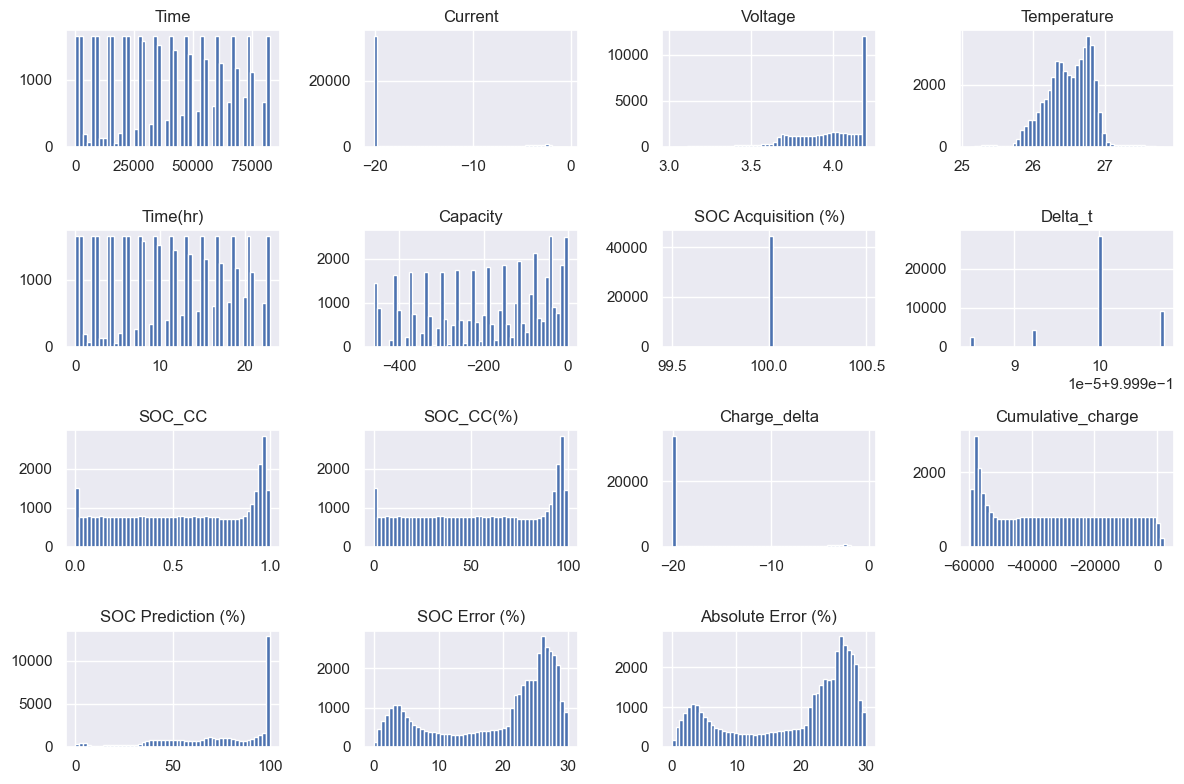

In [30]:
discharged_subset.hist(bins=50 , figsize=(12,8))
plt.tight_layout()
plt.show()

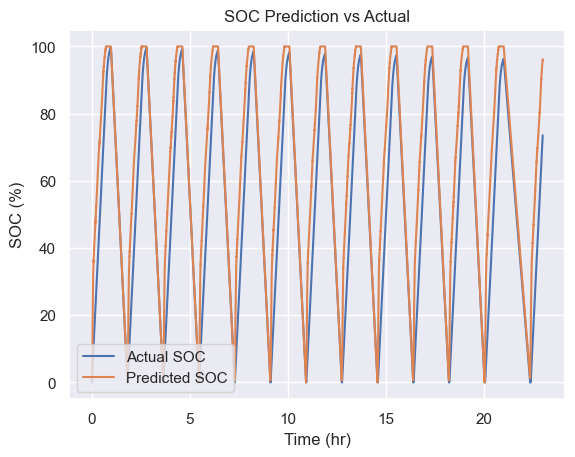

In [31]:
plt.plot(discharged_subset['Time(hr)'], discharged_subset['SOC_CC(%)'], label='Actual SOC')
plt.plot(discharged_subset['Time(hr)'], discharged_subset['SOC Prediction (%)'], label='Predicted SOC')
plt.xlabel('Time (hr)')
plt.ylabel('SOC (%)')
plt.legend()
plt.title('SOC Prediction vs Actual')
plt.show()

In [32]:
charging_subset = merged_subset.loc[merged_subset['Status'] == 'charging']
charging_subset.to_csv('charging_subset.csv', index=False)
charging_subset.head(20)

,Time,Current,Voltage,Temperature,Time(hr),Capacity,SOC Acquisition (%),Delta_t,SOC_CC,SOC_CC(%),Charge_delta,Cumulative_charge,SOC Prediction (%),SOC Error (%),Absolute Error (%),Status
1,1.000008,2.303036,2.999813,27.724861,0.000278,0.000640,99.996151,1.000008,0.000000,0.000000,2.303054,2.303054,0.000000,0.000000,0.000000,charging
2,2.000008,2.284371,2.999863,27.545357,0.000556,0.001269,99.988515,1.000000,0.000000,0.000000,2.284371,4.587424,0.000000,0.000000,0.000000,charging
3,3.000008,2.221588,2.999863,27.457523,0.000833,0.001851,99.977376,1.000000,0.000000,0.000000,2.221588,6.809013,0.000000,0.000000,0.000000,charging
4,4.000008,2.158805,2.999813,27.484249,0.001111,0.002399,99.962943,1.000000,0.000000,0.000000,2.158805,8.967818,0.000000,0.000000,0.000000,charging
5,5.000008,2.096023,2.999311,27.671408,0.001389,0.002911,99.945427,1.000000,0.000000,0.000000,2.096023,11.063841,0.000000,0.000000,0.000000,charging
6,6.000008,2.040028,2.999562,27.610302,0.001667,0.003400,99.924970,1.000000,0.000000,0.000000,2.040028,13.103869,0.000000,0.000000,0.000000,charging
7,7.000008,2.028150,2.999913,27.499533,0.001944,0.003944,99.901241,1.000000,0.000000,0.000000,2.028150,15.132019,0.000000,0.000000,0.000000,charging
3517,3517.000008,19.972104,4.119551,25.815319,0.976944,19.511636,0.000000,1.000008,0.998078,99.807764,19.972256,-59716.981139,94.647881,-5.159882,5.159882,charging
3518,3518.000008,20.006041,4.116494,25.811504,0.977222,19.550348,0.000000,1.000000,0.997743,99.774327,20.006041,-59696.975098,94.366223,-5.408103,5.408103,charging
3519,3519.000008,20.023008,4.114489,25.803852,0.977500,19.572490,0.000000,1.000000,0.997409,99.740861,20.023008,-59676.952090,94.179069,-5.561792,5.561792,charging


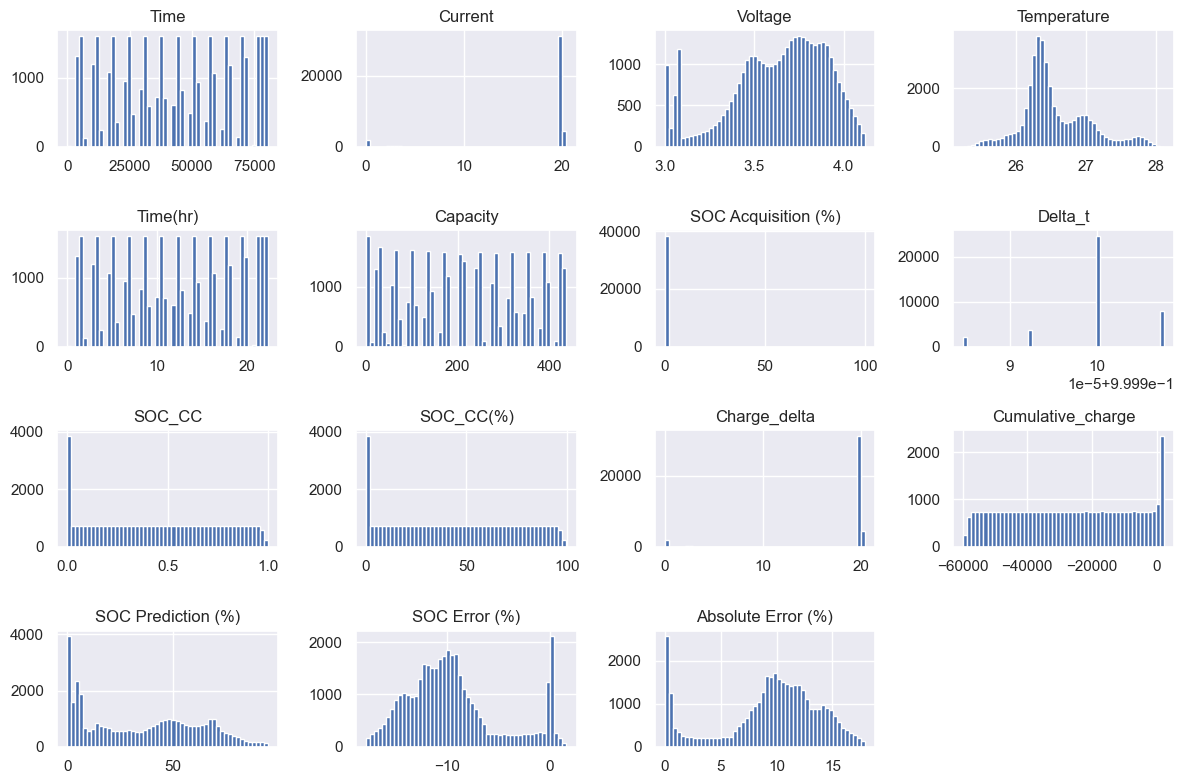

In [33]:
charging_subset.hist(bins=50 , figsize=(12,8))
plt.tight_layout()
plt.show()

In [34]:
soc_ocv.head()

,SOC,V0
0,0.000,3.010470
1,0.001,3.031911
2,0.002,3.049571
3,0.003,3.065900
4,0.004,3.080937


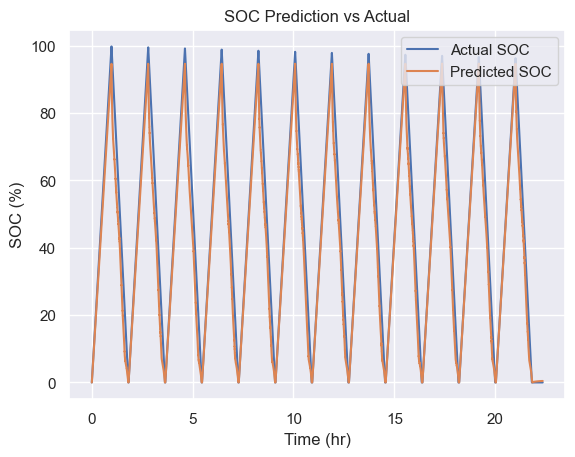

In [35]:
plt.plot(charging_subset['Time(hr)'], charging_subset['SOC_CC(%)'], label='Actual SOC')
plt.plot(charging_subset['Time(hr)'], charging_subset['SOC Prediction (%)'], label='Predicted SOC')
plt.xlabel('Time (hr)')
plt.ylabel('SOC (%)')
plt.legend()
plt.title('SOC Prediction vs Actual')
plt.show()

In [36]:
encoder = OrdinalEncoder()
charging_subset[['SOC Error (%)']] = encoder.fit_transform(charging_subset[['SOC Error (%)']])

In [37]:
from sklearn.preprocessing import StandardScaler
charging_subset_num = charging_subset.select_dtypes(include=['float64', 'int64'])
scaler = StandardScaler()
data_scaled = scaler.fit_transform(charging_subset_num)
print(charging_subset.dtypes)

Time                   float64
Current                float64
Voltage                float64
Temperature            float64
Time(hr)               float64
Capacity               float64
SOC Acquisition (%)    float64
Delta_t                float64
SOC_CC                 float64
SOC_CC(%)              float64
Charge_delta           float64
Cumulative_charge      float64
SOC Prediction (%)     float64
SOC Error (%)          float64
Absolute Error (%)     float64
Status                  object
dtype: object


In [38]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X = pca.fit_transform(data_scaled)

In [39]:
pca.n_components_

6

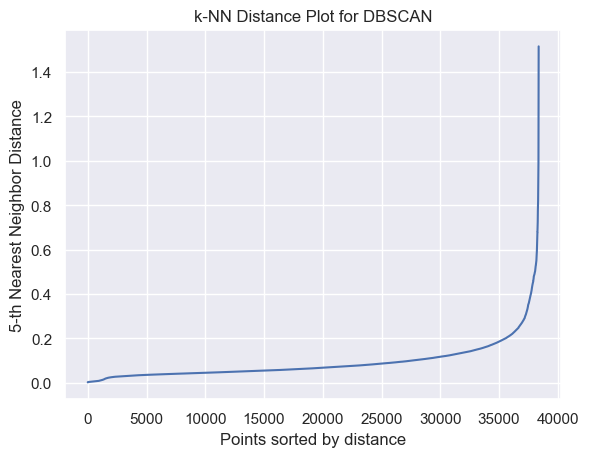

In [40]:
# Choose k = minPts - 1 (DBSCAN min_samples is usually around 4 or 5)
k = 5

# Compute k-NN distances
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X)  # X is your dataset
distances, indices = neighbors_fit.kneighbors(X)

# Sort distances (use the k-th nearest neighbor)
distances = np.sort(distances[:, k-1])

# Plot the sorted distances
plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}-th Nearest Neighbor Distance")
plt.title("k-NN Distance Plot for DBSCAN")
plt.show()

In [41]:
dbscan = DBSCAN(eps= 0.3 , min_samples=7)
dbscan.fit(X)

DBSCAN(eps=0.3, min_samples=7)

In [42]:
dbscan.labels_

array([ -1,  -1,  -1, ..., 113, 114, 114], dtype=int64)

In [43]:
labels = dbscan.labels_

In [44]:
data_new=pd.concat([charging_subset, pd.DataFrame({'type':labels})], axis=1)
data_new.head(20)

,Time,Current,Voltage,Temperature,Time(hr),Capacity,SOC Acquisition (%),Delta_t,SOC_CC,SOC_CC(%),Charge_delta,Cumulative_charge,SOC Prediction (%),SOC Error (%),Absolute Error (%),Status,type
1,1.000008,2.303036,2.999813,27.724861,0.000278,0.000640,99.996151,1.000008,0.000000,0.000000,2.303054,2.303054,0.000000,34730.0,0.000000,charging,-1.0
2,2.000008,2.284371,2.999863,27.545357,0.000556,0.001269,99.988515,1.000000,0.000000,0.000000,2.284371,4.587424,0.000000,34730.0,0.000000,charging,-1.0
3,3.000008,2.221588,2.999863,27.457523,0.000833,0.001851,99.977376,1.000000,0.000000,0.000000,2.221588,6.809013,0.000000,34730.0,0.000000,charging,-1.0
4,4.000008,2.158805,2.999813,27.484249,0.001111,0.002399,99.962943,1.000000,0.000000,0.000000,2.158805,8.967818,0.000000,34730.0,0.000000,charging,-1.0
5,5.000008,2.096023,2.999311,27.671408,0.001389,0.002911,99.945427,1.000000,0.000000,0.000000,2.096023,11.063841,0.000000,34730.0,0.000000,charging,-1.0
6,6.000008,2.040028,2.999562,27.610302,0.001667,0.003400,99.924970,1.000000,0.000000,0.000000,2.040028,13.103869,0.000000,34730.0,0.000000,charging,-1.0
7,7.000008,2.028150,2.999913,27.499533,0.001944,0.003944,99.901241,1.000000,0.000000,0.000000,2.028150,15.132019,0.000000,34730.0,0.000000,charging,-1.0
3517,3517.000008,19.972104,4.119551,25.815319,0.976944,19.511636,0.000000,1.000008,0.998078,99.807764,19.972256,-59716.981139,94.647881,31484.0,5.159882,charging,9.0
3518,3518.000008,20.006041,4.116494,25.811504,0.977222,19.550348,0.000000,1.000000,0.997743,99.774327,20.006041,-59696.975098,94.366223,31328.0,5.408103,charging,9.0
3519,3519.000008,20.023008,4.114489,25.803852,0.977500,19.572490,0.000000,1.000000,0.997409,99.740861,20.023008,-59676.952090,94.179069,31239.0,5.561792,charging,9.0


In [45]:
# Convert string 'NaN' or similar to np.nan
charging_subset.replace(['NaN', 'null', 'N/A', '--'], np.nan, inplace=True)

# Now check missing values
print(charging_subset.isna().sum())

Time                   0
Current                0
Voltage                0
Temperature            0
Time(hr)               0
Capacity               0
SOC Acquisition (%)    0
Delta_t                0
SOC_CC                 0
SOC_CC(%)              0
Charge_delta           0
Cumulative_charge      0
SOC Prediction (%)     0
SOC Error (%)          0
Absolute Error (%)     0
Status                 0
dtype: int64


In [46]:
# Drop rows with missing values
charging_subset.dropna(inplace=True)

# Or fill them with a method or value
charging_subset.fillna(method='ffill', inplace=True)  # forward fill
# or
charging_subset.fillna(0, inplace=True)               # fill with zero

In [47]:
charging_subset.replace(['NaN', 'null', 'N/A'], np.nan, inplace=True)

print(charging_subset.isna().sum())  # Now it will show proper missing values

Time                   0
Current                0
Voltage                0
Temperature            0
Time(hr)               0
Capacity               0
SOC Acquisition (%)    0
Delta_t                0
SOC_CC                 0
SOC_CC(%)              0
Charge_delta           0
Cumulative_charge      0
SOC Prediction (%)     0
SOC Error (%)          0
Absolute Error (%)     0
Status                 0
dtype: int64


In [48]:
# Compare anomaly vs normal points
normal = data_new[data_new['type'] != -1]
anomalies = data_new[data_new['type'] == -1]

# Describe and compare
print("Normal range:", normal['Capacity'].describe())
print("Anomalous range:", anomalies['Capacity'].describe())

# Repeat for other variables...

Normal range: count    37714.000000
mean       215.735576
std        132.794338
min         -0.000000
25%         99.614766
50%        212.795899
75%        324.399609
max        437.885749
Name: Capacity, dtype: float64
Anomalous range: count    652.000000
mean     107.693713
std       55.678851
min        0.000640
25%       66.452782
50%      101.593490
75%      166.574279
max      204.162837
Name: Capacity, dtype: float64


In [49]:
def convert(value):
    try:
        value = float(value)  # Convert to float if possible
    except ValueError:
        return value  # Return original if conversion fails (e.g., non-numeric strings)
    
    # Example condition to avoid TypeError
    if value == -1:  
        return "Anomalous"
    else:
        return "Normal"

data_new['type'] = data_new['type'].apply(convert)

In [50]:
data_new.head(30)

,Time,Current,Voltage,Temperature,Time(hr),Capacity,SOC Acquisition (%),Delta_t,SOC_CC,SOC_CC(%),Charge_delta,Cumulative_charge,SOC Prediction (%),SOC Error (%),Absolute Error (%),Status,type
1,1.000008,2.303036,2.999813,27.724861,0.000278,0.000640,99.996151,1.000008,0.000000,0.000000,2.303054,2.303054,0.000000,34730.0,0.000000,charging,Anomalous
2,2.000008,2.284371,2.999863,27.545357,0.000556,0.001269,99.988515,1.000000,0.000000,0.000000,2.284371,4.587424,0.000000,34730.0,0.000000,charging,Anomalous
3,3.000008,2.221588,2.999863,27.457523,0.000833,0.001851,99.977376,1.000000,0.000000,0.000000,2.221588,6.809013,0.000000,34730.0,0.000000,charging,Anomalous
4,4.000008,2.158805,2.999813,27.484249,0.001111,0.002399,99.962943,1.000000,0.000000,0.000000,2.158805,8.967818,0.000000,34730.0,0.000000,charging,Anomalous
5,5.000008,2.096023,2.999311,27.671408,0.001389,0.002911,99.945427,1.000000,0.000000,0.000000,2.096023,11.063841,0.000000,34730.0,0.000000,charging,Anomalous
6,6.000008,2.040028,2.999562,27.610302,0.001667,0.003400,99.924970,1.000000,0.000000,0.000000,2.040028,13.103869,0.000000,34730.0,0.000000,charging,Anomalous
7,7.000008,2.028150,2.999913,27.499533,0.001944,0.003944,99.901241,1.000000,0.000000,0.000000,2.028150,15.132019,0.000000,34730.0,0.000000,charging,Anomalous
3517,3517.000008,19.972104,4.119551,25.815319,0.976944,19.511636,0.000000,1.000008,0.998078,99.807764,19.972256,-59716.981139,94.647881,31484.0,5.159882,charging,Normal
3518,3518.000008,20.006041,4.116494,25.811504,0.977222,19.550348,0.000000,1.000000,0.997743,99.774327,20.006041,-59696.975098,94.366223,31328.0,5.408103,charging,Normal
3519,3519.000008,20.023008,4.114489,25.803852,0.977500,19.572490,0.000000,1.000000,0.997409,99.740861,20.023008,-59676.952090,94.179069,31239.0,5.561792,charging,Normal


In [51]:
print(data_new.columns.tolist())

['Time', 'Current', 'Voltage', 'Temperature', 'Time(hr)', 'Capacity', 'SOC Acquisition (%)', 'Delta_t', 'SOC_CC', 'SOC_CC(%)', 'Charge_delta', 'Cumulative_charge', 'SOC Prediction (%)', 'SOC Error (%)', 'Absolute Error (%)', 'Status', 'type']


In [52]:
print(data_new[data_new['type'] == 'Anomalous'])

           Time   Current   Voltage  Temperature  Time(hr)  Capacity  \
1      1.000008  2.303036  2.999813    27.724861  0.000278  0.000640   
2      2.000008  2.284371  2.999863    27.545357  0.000556  0.001269   
3      3.000008  2.221588  2.999863    27.457523  0.000833  0.001851   
4      4.000008  2.158805  2.999813    27.484249  0.001111  0.002399   
5      5.000008  2.096023  2.999311    27.671408  0.001389  0.002911   
...         ...       ...       ...          ...       ...       ...   
36206       NaN       NaN       NaN          NaN       NaN       NaN   
36230       NaN       NaN       NaN          NaN       NaN       NaN   
36245       NaN       NaN       NaN          NaN       NaN       NaN   
36269       NaN       NaN       NaN          NaN       NaN       NaN   
36293       NaN       NaN       NaN          NaN       NaN       NaN   

       SOC Acquisition (%)   Delta_t  SOC_CC  SOC_CC(%)  Charge_delta  \
1                99.996151  1.000008     0.0        0.0      2

In [53]:
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points (anomalies): {n_noise}")

Estimated number of clusters: 117
Estimated number of noise points (anomalies): 1395


<Axes: xlabel='type', ylabel='count'>

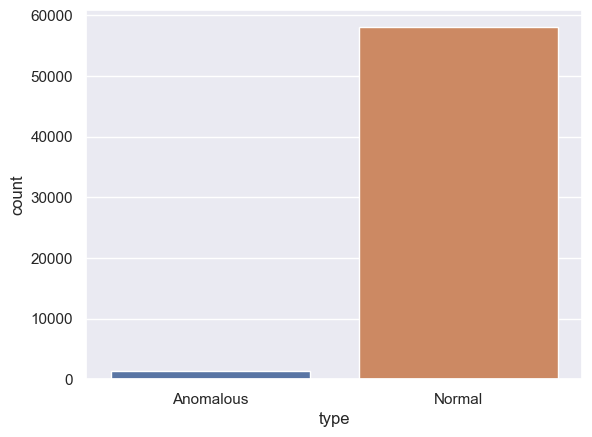

In [54]:
sn.countplot(x ='type' , data=data_new)

In [55]:
y = encoder.fit_transform(data_new[['type']])

In [56]:
print(X.shape)

(38366, 6)


In [57]:
print(type(X))

<class 'numpy.ndarray'>


In [58]:
print(len(X[:, 0]), len(X[:, 1]), len(X[:, 2]), len(y))

38366 38366 38366 59422


In [59]:
unique_labels = set(labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

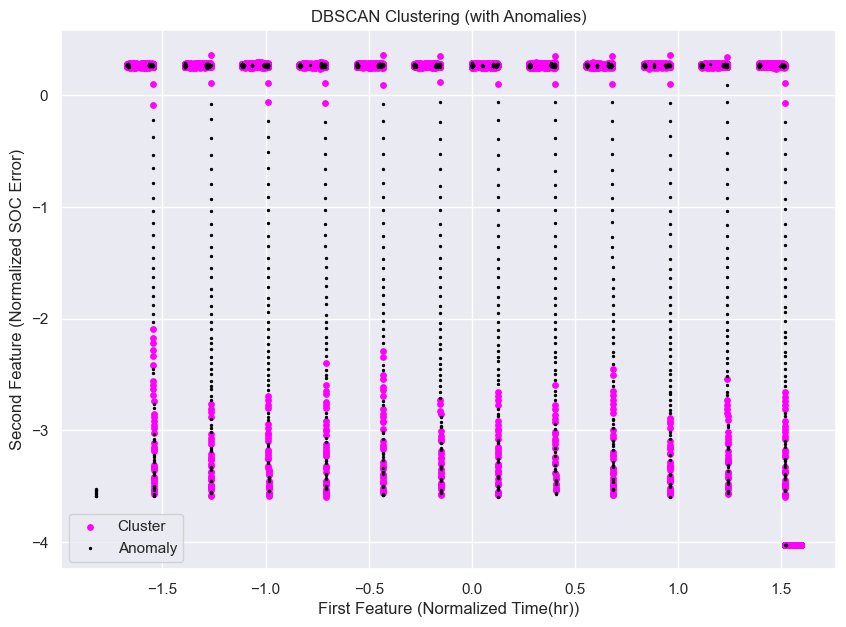

In [60]:
plt.figure(figsize=(10,7))

# Normal points
plt.scatter(data_scaled[labels != -1, 0], data_scaled[labels != -1, 1],
            c='magenta', cmap='plasma', s=15, label='Cluster')

# Anomalies
plt.scatter(data_scaled[labels == -1, 0], data_scaled[labels == -1, 1],
            c='black', s=2, label='Anomaly')

plt.xlabel('First Feature (Normalized Time(hr))')
plt.ylabel('Second Feature (Normalized SOC Error)')
plt.title('DBSCAN Clustering (with Anomalies)')
plt.legend()
plt.show()

In [61]:
print(charging_subset_num.columns)

Index(['Time', 'Current', 'Voltage', 'Temperature', 'Time(hr)', 'Capacity',
       'SOC Acquisition (%)', 'Delta_t', 'SOC_CC', 'SOC_CC(%)', 'Charge_delta',
       'Cumulative_charge', 'SOC Prediction (%)', 'SOC Error (%)',
       'Absolute Error (%)'],
      dtype='object')


In [62]:
# Assume anomalies are defined as sudden SOC jumps > 10%
merged_subset['soc_diff'] = merged_subset['SOC Acquisition (%)'].diff().abs()
anomaly_mask = merged_subset['soc_diff'] > 10
merged_subset['anomaly mask'] = anomaly_mask
merged_subset.head(10)

,Time,Current,Voltage,Temperature,Time(hr),Capacity,SOC Acquisition (%),Delta_t,SOC_CC,SOC_CC(%),Charge_delta,Cumulative_charge,SOC Prediction (%),SOC Error (%),Absolute Error (%),Status,soc_diff,anomaly mask
1,1.000008,2.303036,2.999813,27.724861,0.000278,0.000640,99.996151,1.000008,0.000000,0.000000,2.303054,2.303054,0.000000,0.000000,0.000000,charging,NaN,False
2,2.000008,2.284371,2.999863,27.545357,0.000556,0.001269,99.988515,1.000000,0.000000,0.000000,2.284371,4.587424,0.000000,0.000000,0.000000,charging,0.007636,False
3,3.000008,2.221588,2.999863,27.457523,0.000833,0.001851,99.977376,1.000000,0.000000,0.000000,2.221588,6.809013,0.000000,0.000000,0.000000,charging,0.011139,False
4,4.000008,2.158805,2.999813,27.484249,0.001111,0.002399,99.962943,1.000000,0.000000,0.000000,2.158805,8.967818,0.000000,0.000000,0.000000,charging,0.014432,False
5,5.000008,2.096023,2.999311,27.671408,0.001389,0.002911,99.945427,1.000000,0.000000,0.000000,2.096023,11.063841,0.000000,0.000000,0.000000,charging,0.017516,False
6,6.000008,2.040028,2.999562,27.610302,0.001667,0.003400,99.924970,1.000000,0.000000,0.000000,2.040028,13.103869,0.000000,0.000000,0.000000,charging,0.020458,False
7,7.000008,2.028150,2.999913,27.499533,0.001944,0.003944,99.901241,1.000000,0.000000,0.000000,2.028150,15.132019,0.000000,0.000000,0.000000,charging,0.023728,False
8,8.000015,-20.049273,3.108820,27.526283,0.002222,-0.044554,100.000000,1.000008,0.000082,0.008219,-20.049426,-4.917407,0.602738,0.594519,0.594519,discharge,0.098759,False
9,9.000000,-20.017035,3.119144,27.476620,0.002500,-0.050043,100.000000,0.999985,0.000417,0.041674,-20.016730,-24.934137,0.684802,0.643128,0.643128,discharge,0.000000,False
10,10.000008,-20.013641,3.128115,27.549194,0.002778,-0.055593,100.000000,1.000008,0.000751,0.075124,-20.013794,-44.947930,0.759230,0.684106,0.684106,discharge,0.000000,False


In [63]:
merged_subset['soc_diff'] = merged_subset['SOC Acquisition (%)'].diff().abs()
merged_subset['anomaly'] = merged_subset['soc_diff'] > 10
anomalies = merged_subset[merged_subset['anomaly']]

In [64]:
mask1 = merged_subset['SOC Acquisition (%)'].diff().abs() > 10
mask1 = mask1.fillna(False)  # Optional: treat NaN as not anomalous
merged_subset = merged_subset[mask1]

In [65]:
print(charging_subset_num.columns.tolist())

['Time', 'Current', 'Voltage', 'Temperature', 'Time(hr)', 'Capacity', 'SOC Acquisition (%)', 'Delta_t', 'SOC_CC', 'SOC_CC(%)', 'Charge_delta', 'Cumulative_charge', 'SOC Prediction (%)', 'SOC Error (%)', 'Absolute Error (%)']


In [66]:
merged_subset['SOC_diff'] = merged_subset['SOC Prediction (%)'].diff().abs()
jump_threshold = 20  # tweak if needed
jump_anomalies = merged_subset[merged_subset['SOC_diff'] > jump_threshold]

In [67]:
anomaly = data_new.loc[data_new['type'] == 'Anomalous']
anomaly.to_csv('anomalies.csv', index=False)
anomaly.head(10)


,Time,Current,Voltage,Temperature,Time(hr),Capacity,SOC Acquisition (%),Delta_t,SOC_CC,SOC_CC(%),Charge_delta,Cumulative_charge,SOC Prediction (%),SOC Error (%),Absolute Error (%),Status,type
1,1.000008,2.303036,2.999813,27.724861,0.000278,0.000640,99.996151,1.000008,0.000000,0.000000,2.303054,2.303054,0.000000,34730.0,0.000000,charging,Anomalous
2,2.000008,2.284371,2.999863,27.545357,0.000556,0.001269,99.988515,1.000000,0.000000,0.000000,2.284371,4.587424,0.000000,34730.0,0.000000,charging,Anomalous
3,3.000008,2.221588,2.999863,27.457523,0.000833,0.001851,99.977376,1.000000,0.000000,0.000000,2.221588,6.809013,0.000000,34730.0,0.000000,charging,Anomalous
4,4.000008,2.158805,2.999813,27.484249,0.001111,0.002399,99.962943,1.000000,0.000000,0.000000,2.158805,8.967818,0.000000,34730.0,0.000000,charging,Anomalous
5,5.000008,2.096023,2.999311,27.671408,0.001389,0.002911,99.945427,1.000000,0.000000,0.000000,2.096023,11.063841,0.000000,34730.0,0.000000,charging,Anomalous
6,6.000008,2.040028,2.999562,27.610302,0.001667,0.003400,99.924970,1.000000,0.000000,0.000000,2.040028,13.103869,0.000000,34730.0,0.000000,charging,Anomalous
7,7.000008,2.028150,2.999913,27.499533,0.001944,0.003944,99.901241,1.000000,0.000000,0.000000,2.028150,15.132019,0.000000,34730.0,0.000000,charging,Anomalous
5484,5484.000008,19.983980,3.579830,26.663160,1.523333,30.442263,0.000000,1.000000,0.340854,34.085416,19.983980,-20393.986035,21.450769,9310.0,12.634646,charging,Anomalous
5499,5499.000008,19.972104,3.575519,26.518034,1.527500,30.507389,0.000000,1.000000,0.335839,33.583900,19.972104,-20093.919199,20.860807,9004.0,12.723094,charging,Anomalous
5508,5508.000008,20.019613,3.572863,26.777719,1.530000,30.630008,0.000000,1.000000,0.332831,33.283103,20.019613,-19913.946288,20.512393,8810.0,12.770710,charging,Anomalous


In [68]:
upper_cutoff = 4.2
lower_cutoff = 3.0

cutoff_anomalies = anomaly[
    (anomaly['Voltage'] >= upper_cutoff) |
    (anomaly['Voltage'] <= lower_cutoff)
]

In [69]:
anomaly['SOC_diff'] = anomaly['Absolute Error (%)']

# Step 2: Define thresholds
jump_threshold = 10
upper_cutoff = 4.2
lower_cutoff = 3.0

# Step 3: Detect types of anomalies
anomaly['is_jump'] = anomaly['SOC_diff'] > jump_threshold
anomaly['is_cutoff'] = (anomaly['Voltage'] >= upper_cutoff) | (anomaly['Voltage'] <= lower_cutoff)

# Step 4: Assign anomaly cause
def detect_cause(row):
    if   row['is_jump']:
        return 'Recalibration'
    elif row['is_cutoff']:
        return 'Voltage Cut-off'
    else:
        return

anomaly['Anomaly Cause'] = anomaly.apply(detect_cause, axis=1)
#data_new.head(20)
anomaly[['Time(hr)', 'SOC Prediction (%)', 'Voltage', 'SOC_diff', 'Anomaly Cause']].head(10)

,Time(hr),SOC Prediction (%),Voltage,SOC_diff,Anomaly Cause
1,0.000278,0.000000,2.999813,0.000000,Voltage Cut-off
2,0.000556,0.000000,2.999863,0.000000,Voltage Cut-off
3,0.000833,0.000000,2.999863,0.000000,Voltage Cut-off
4,0.001111,0.000000,2.999813,0.000000,Voltage Cut-off
5,0.001389,0.000000,2.999311,0.000000,Voltage Cut-off
6,0.001667,0.000000,2.999562,0.000000,Voltage Cut-off
7,0.001944,0.000000,2.999913,0.000000,Voltage Cut-off
5484,1.523333,21.450769,3.579830,12.634646,Recalibration
5499,1.527500,20.860807,3.575519,12.723094,Recalibration
5508,1.530000,20.512393,3.572863,12.770710,Recalibration


In [70]:
cutoff = anomaly[anomaly['Anomaly Cause'] == 'Voltage Cut-off']
print(cutoff)

       Time   Current   Voltage  Temperature  Time(hr)  Capacity  \
1  1.000008  2.303036  2.999813    27.724861  0.000278  0.000640   
2  2.000008  2.284371  2.999863    27.545357  0.000556  0.001269   
3  3.000008  2.221588  2.999863    27.457523  0.000833  0.001851   
4  4.000008  2.158805  2.999813    27.484249  0.001111  0.002399   
5  5.000008  2.096023  2.999311    27.671408  0.001389  0.002911   
6  6.000008  2.040028  2.999562    27.610302  0.001667  0.003400   
7  7.000008  2.028150  2.999913    27.499533  0.001944  0.003944   

   SOC Acquisition (%)   Delta_t  SOC_CC  SOC_CC(%)  ...  Cumulative_charge  \
1            99.996151  1.000008     0.0        0.0  ...           2.303054   
2            99.988515  1.000000     0.0        0.0  ...           4.587424   
3            99.977376  1.000000     0.0        0.0  ...           6.809013   
4            99.962943  1.000000     0.0        0.0  ...           8.967818   
5            99.945427  1.000000     0.0        0.0  ...    

In [71]:
X = data_new.drop(['type'],axis=1)

In [72]:
X = data_new.drop(['Status'],axis=1)

In [73]:
from sklearn.model_selection import train_test_split
X_train ,X_test , y_train , y_test = train_test_split(X , y , test_size=0.2 , random_state=42)

In [74]:
X_train.shape

(47537, 16)

In [75]:
y_train.shape

(47537, 1)

In [76]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(data_new, test_size=0.2, random_state=42)

In [77]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score

features = ['SOC_CC(%)', 'SOC Prediction (%)', 'SOC Error (%)']  # numeric columns

# Imputer
imputer = SimpleImputer(strategy='mean')
imputer.fit(df_train[features])

X_train = imputer.transform(df_train[features])
X_test = imputer.transform(df_test[features])

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(df_train['Status'])
y_test = le.transform(df_test['Status'])

# Train LOF
clf = LocalOutlierFactor(n_neighbors=7, contamination=0.5, novelty=True)
clf.fit(X_train)

# Predict
y_pred = clf.predict(X_test)
y_pred = [0 if x == -1 else 1 for x in y_pred]

acc = accuracy_score(y_test, y_pred) * 100
print(f"Accuracy of the model : {acc} %")

Accuracy of the model : 82.81867900715187 %


In [78]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=117)
clf.fit(X_train , y_train)
y_pred = clf.predict(X_test)

# Predict
y_pred = clf.predict(X_test)
y_pred = [0 if x == -1 else 1 for x in y_pred]

acc = accuracy_score(y_test, y_pred) * 100
print(f"Accuracy of the model : {acc} %")

Accuracy of the model : 35.7004627681952 %


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier

clf = IsolationForest(n_estimators=117)
clf.fit(X_train , y_train)
y_pred = clf.predict(X_test)

# Predict
y_pred = clf.predict(X_test)
y_pred = [0 if x == -1 else 1 for x in y_pred]

acc = accuracy_score(y_test, y_pred) * 100
print(f"Accuracy of the model : {acc} %")

Accuracy of the model : 91.89734960033657 %


: 